# Seguridad Vial

In [1]:
import pandas as pd
import numpy as np

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
import seaborn as sns

In [3]:
import matplotlib.pyplot as plt

In [4]:
import geopandas as gpd

In [5]:
import contextily as cx

In [6]:
from pyproj import Proj, transform

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
pd.set_option('display.max_columns', None)

## Cargando datos

In [9]:
df = pd.read_csv('data/external/siniestros_individuales_conaset/individuales_biobio_2020.csv')

In [10]:
df.sample()

,X,Y,FID,COD_REG,REGION,CUT,COMUNA,CALLE_UNO,CALLE_DOS,NUMERO,DIR_GEOCOD,LAT,LNG,VAL_COM,TIPO,Año,Idaccident,Fecha,Tipo_Accid,Tipo__CONA,Zona,Causa__CON,Causa,Fallecidos,Graves,Menos_Grav,Leves,Hora
481,-73.114699,-36.768764,482,8,REGION BIO BIO,8110,TALCAHUANO,GRAN BRETAÑA,,4889,"Gran Bretaña 4889, Talcahuano, Bío Bío, Chile",-36.768764,-73.114699,1,ROOFTOP,2020,1305782,2020/10/17 00:00:00+00,VOLCADURA,VOLCADURA,URBANA,PERDIDA CONTROL VEHICULO,PERDIDA CONTROL VEHICULO,0,0,0,1,19:00:00


In [11]:
df.shape

(4482, 28)

Seleccionando variables

In [12]:
df = df[['LNG','LAT','FID','Fecha','Hora','CALLE_UNO','CALLE_DOS', 'NUMERO', 'COMUNA', 'COD_REG']]

Creando variables nuevas

In [13]:
df.rename(columns = {'LNG':'Longitude', 'LAT':'Latitude'}, inplace = True)

In [14]:
df['Fecha'] = df['Fecha'].apply(lambda x: x[:10])
df['fecha_hora'] = pd.to_datetime(df['Fecha'] + ' ' + df['Hora']) 

In [15]:
df['dow'] = df['fecha_hora'].dt.dayofweek

In [16]:
df['hour'] = df['fecha_hora'].dt.hour

Longitud y latitud

In [17]:
df['Longitude'], df['Latitude'] = transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), df.Longitude, df.Latitude)  # longitude first, latitude second.

In [18]:
df_geo = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude, crs = "EPSG:3857"))

## Mapa de Chile

In [19]:
chile = gpd.read_file('data/internal/comunas/comunas.shp')

In [20]:
chile.crs

<Derived Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Calles

In [21]:
calles = gpd.read_file('data/external/maestro_calles_2018/MAESTRO_EJES.shp')

## Graficos

In [22]:
heatmap_accidentes = pd.pivot_table(values = 'FID', index = 'hour', columns = 'dow', aggfunc = 'count', data = df[df['COMUNA']=='CONCEPCION'])
heatmap_accidentes.fillna(0, inplace = True)

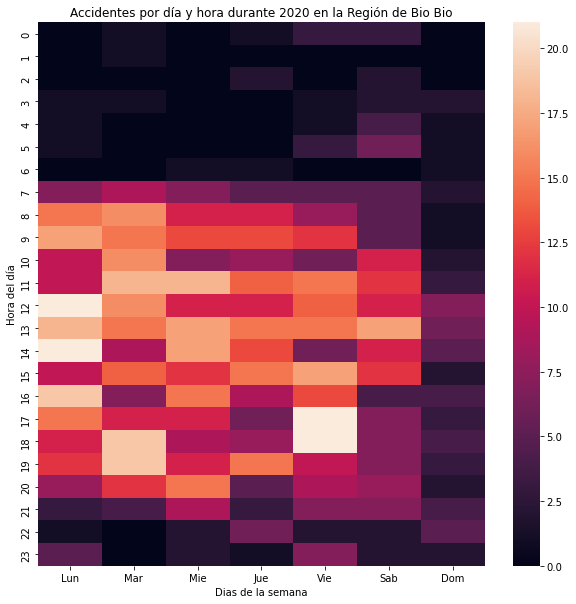

In [23]:
fig, ax = plt.subplots(1,1,figsize = (10, 10))
s = sns.heatmap(heatmap_accidentes, xticklabels=['Lun', 'Mar', 'Mie', 'Jue', 'Vie', 'Sab', 'Dom'], ax = ax)
s.set(xlabel='Dias de la semana', ylabel='Hora del día')
s.set_title('Accidentes por día y hora durante 2020 en la Región de Bio Bio');

## Mapas

In [25]:
df_wm = chile[(chile['codregion']==8) & (chile['Comuna'].isin'Concepción')]

(-8140000.0, -8125000.0)

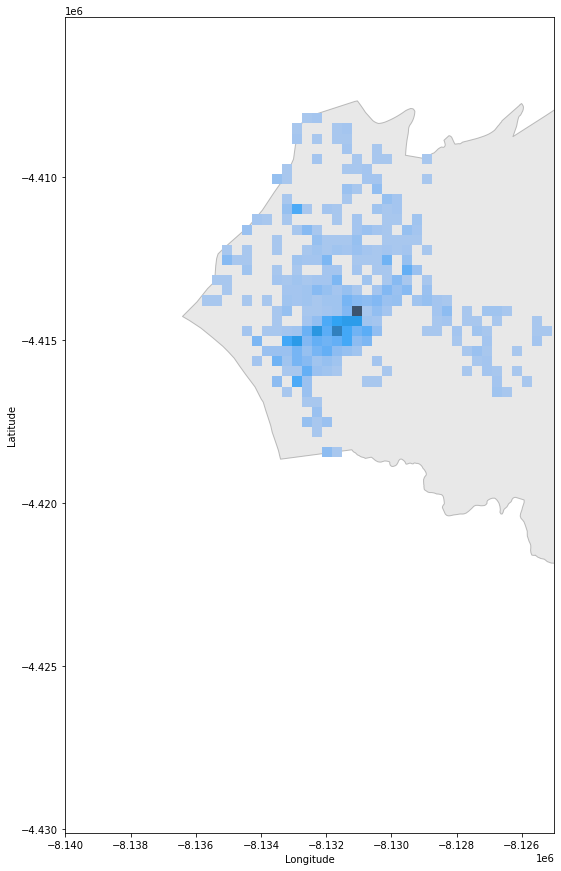

In [26]:
fig, ax = plt.subplots(1,1,figsize=(15,15))
df_wm.plot(
    color = 'lightgray',
    edgecolor="gray",
    alpha = 0.5,
    ax = ax
)



sns.histplot(
    x = 'Longitude', 
    y = 'Latitude',
    kde = True,
    ax = ax,
    data = df[df['COMUNA']=='CONCEPCION']
)

ax.set_xlim([-8.14E6,-8.125E6])
#ax.set_ylim([-4.05E6,-4.225E6])

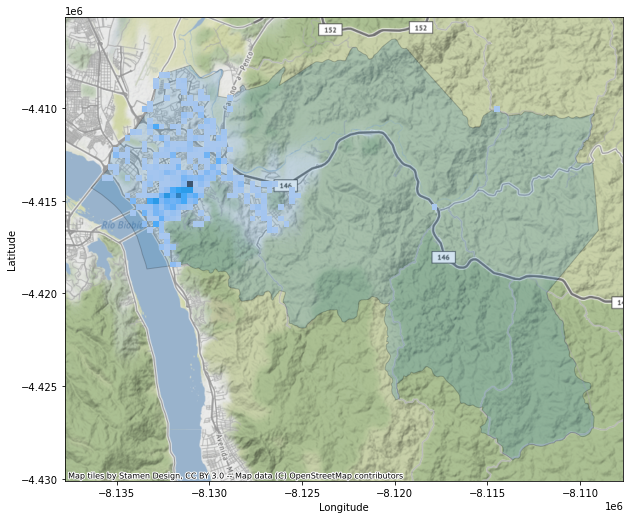

In [34]:
ax = df_wm.plot(figsize=(10, 10), alpha=0.2, edgecolor='k')

sns.histplot(
    x = 'Longitude', 
    y = 'Latitude',
    kde = True,
    ax = ax,
    data = df[df['COMUNA']=='CONCEPCION']
)

cx.add_basemap(ax)

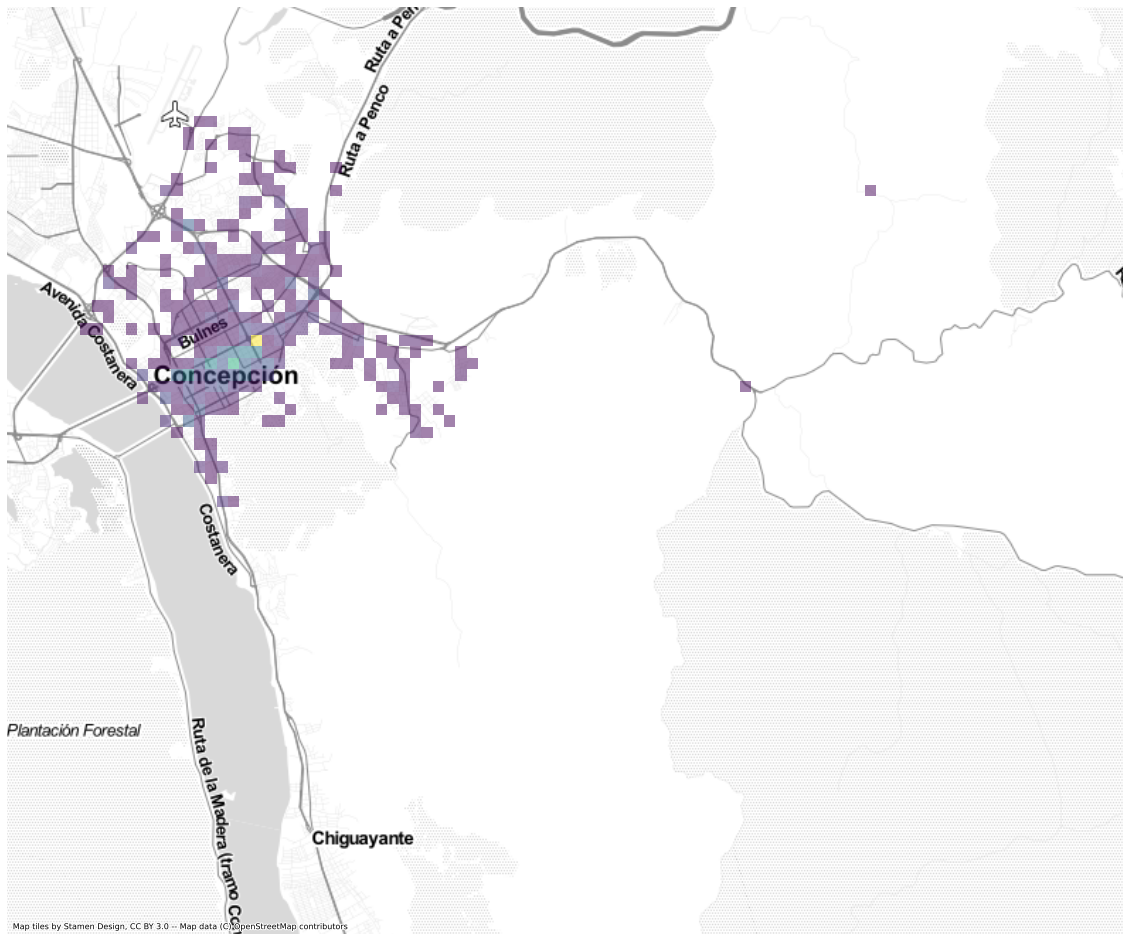

In [61]:
ax = df_wm.plot(figsize=(20, 20), alpha=0, edgecolor='k')
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite)

sns.histplot(
    x = 'Longitude', 
    y = 'Latitude',
    element = 'poly',
    kde = True,
    alpha = 0.5,
    cmap = 'viridis',
    ax = ax,
    data = df[df['COMUNA']=='CONCEPCION'] 
)
ax.set_axis_off()


plt.savefig('concepcion.jpg')